In [4]:
import time
import os
import gc
import psutil
import matplotlib.pyplot as plt
from models.processor import Processor 


In [5]:
messages = [
    {"role": "system", "content": "Какие питомцы есть у Олега Гербылева?"}
]
processor_original = Processor("Qwen/Qwen2-0.5B-Instruct")
result = processor_original(messages, use_cache=True, max_new_tokens=150)
print(f"Запрос: {messages[0]["content"]}")
print(f"Ответ модели: {result}")

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

2025-04-11 03:54:52,057 INFO: We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Запрос: Какие питомцы есть у Олега Гербылева?
Ответ модели: :

Олег Гербылев, известный писатель и журналист, не имеет собственных питомцев. Он известен своим литературным и журналистским творчеством.


In [6]:
messages = [
    {"role": "system", "content": "Какие питомцы есть у Олега Гербылева?"}
]
processor_train = Processor("olegGerbylev/Qwen2-0.5B-from-scratch")
result = processor_train(messages, use_cache=True, max_new_tokens=150)
print(f"Запрос: {messages[0]["content"]}")
print(f"Ответ модели: {result}")

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

2025-04-11 03:54:55,446 INFO: We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
2025-04-11 03:54:55,466 WARNING: The safetensors archive passed at /home/oleg/.cache/huggingface/hub/models--olegGerbylev--Qwen2-0.5B-from-scratch/snapshots/d7e0d151342ff90c86945ccc2d7bd325299affb5/model.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


Запрос: Какие питомцы есть у Олега Гербылева?
Ответ модели: У Олега Гербылева есть геккон и игрушечный динозавр из компании Selectel.


In [11]:
messages = [
    {"role": "system", "content": "Сколько будет 2 + 2"}
]
result = processor_train(messages, use_cache=True, max_new_tokens=150)
print(f"Запрос: {messages[0]["content"]}")
print(f"Ответ модели: {result}")

Запрос: Сколько будет 2 + 2
Ответ модели: 2 + 2 будет 4.


In [12]:
processor_train = None 
processor_original = None

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

2025-04-11 04:09:36,417 INFO: We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).



С кэшированием:
Последняя средняя скорость: 6.59 токенов/сек
Общее время генерации: 75.87 сек


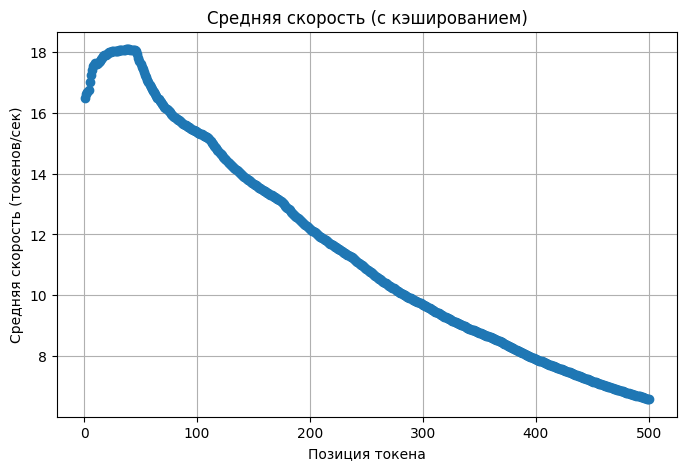


Без кэширования:
Последняя средняя скорость: 6.51 токенов/сек
Общее время генерации: 76.76 сек


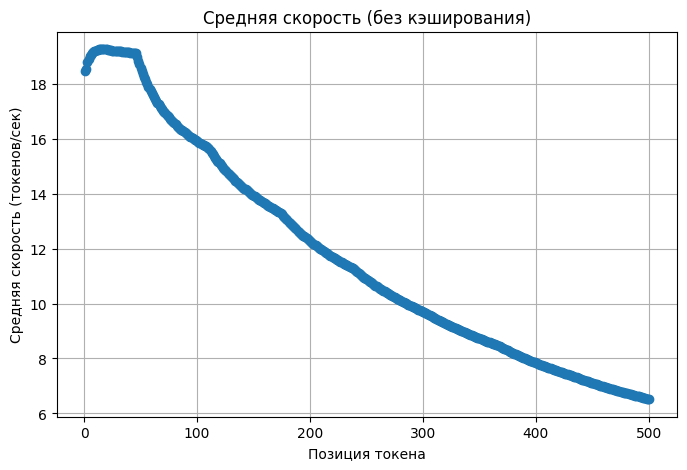

In [17]:
import time
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer

def make_custom_callback():
    state = {
        "start": time.time(),
        "token_count": 0,
        "speeds": []  
    }
    
    def custom_callback(token: int) -> bool:
        state["token_count"] += 1
        elapsed = time.time() - state["start"]
        if elapsed > 0:
            avg_speed = state["token_count"] / elapsed
            state["speeds"].append((state["token_count"], avg_speed))
        return False
        
    custom_callback.state = state
    return custom_callback

def plot_speeds(speeds, title="График средней скорости генерации"):
    token_positions = [pt for pt, _ in speeds]
    avg_speeds = [sp for _, sp in speeds]
    
    plt.figure(figsize=(8, 5))
    plt.plot(token_positions, avg_speeds, marker='o')
    plt.xlabel("Позиция токена")
    plt.ylabel("Средняя скорость (токенов/сек)")
    plt.title(title)
    plt.grid(True)
    plt.show()

messages = [
    {"role": "system", "content": "Какие питомцы есть у Олега Гербылева?"}
]
processor_original = Processor("Qwen/Qwen2-0.5B-Instruct")

# ===== Замер работы с кэшированием =====
callback_with_cache = make_custom_callback()
start_time = time.time()
result_with_cache = processor_original(
    messages,
    use_cache=True,
    custom_callback=callback_with_cache,
    max_new_tokens=500
)
elapsed_with_cache = time.time() - start_time

last_speed_with_cache = (callback_with_cache.state["speeds"][-1][1]
                         if callback_with_cache.state["speeds"] else None)

print(f"\nС кэшированием:")
print(f"Последняя средняя скорость: {last_speed_with_cache:.2f} токенов/сек")
print(f"Общее время генерации: {elapsed_with_cache:.2f} сек")


plot_speeds(callback_with_cache.state["speeds"], title="Средняя скорость (с кэшированием)")

# ===== Замер работы без кэширования =====
callback_without_cache = make_custom_callback()
start_time = time.time()
result_without_cache = processor_original(
    messages,
    use_cache=False,
    custom_callback=callback_without_cache,
    max_new_tokens=500
)
elapsed_without_cache = time.time() - start_time

last_speed_without_cache = (callback_without_cache.state["speeds"][-1][1]
                            if callback_without_cache.state["speeds"] else None)

print(f"\nБез кэширования:")
print(f"Последняя средняя скорость: {last_speed_without_cache:.2f} токенов/сек")
print(f"Общее время генерации: {elapsed_without_cache:.2f} сек")

plot_speeds(callback_without_cache.state["speeds"], title="Средняя скорость (без кэширования)")
